In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as onp
import pandas as pd

In [8]:
import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
import numpyro.distributions as nd
from numpyro.infer import MCMC, NUTS

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import palettes

palettes.set_theme()

In [13]:
D = pd.read_csv("../data/elections.csv")
D.loc[:, "proportion"] = D.dem / (D.dem + D.rep)
D

,year,dem,rep,region,state,proportion
0,1976,44058,71555,Mountain West,AK,0.381082
1,1980,41842,86112,Mountain West,AK,0.327008
2,1984,62007,138377,Mountain West,AK,0.309441
3,1988,72584,119251,Mountain West,AK,0.378367
4,1992,78294,102000,Mountain West,AK,0.434257
...,...,...,...,...,...,...
545,2000,60481,147947,Mountain West,WY,0.290177
546,2004,70776,167629,Mountain West,WY,0.296873
547,2008,82868,164958,Mountain West,WY,0.334380
548,2012,69286,170962,Mountain West,WY,0.288394


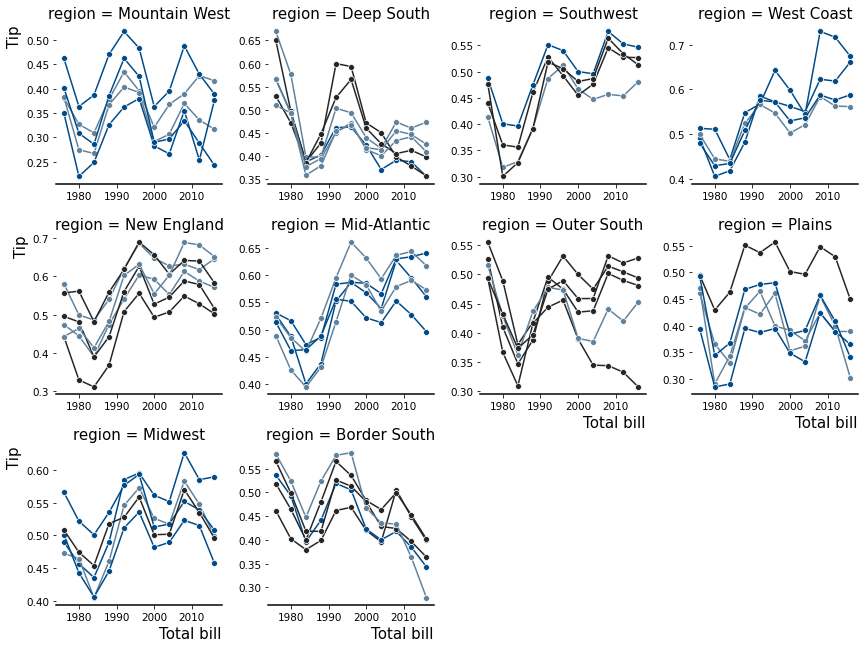

In [14]:
g = sns.FacetGrid(
    D, 
    col="region",
    hue="state",
    palette=palettes.discrete_sequential_colors(),     
    col_wrap=4,
    sharex=False, 
    sharey=False
)
g.map_dataframe(sns.lineplot, x="year", y="proportion", style="state", markers="o")
g.set_axis_labels("Total bill", "Tip")
sns.despine(left=True)
plt.show()

In [15]:
def rbf(X1, X2, sigma=1.0, rho=1.0, jitter=1.0e-6):
    X1_e = np.expand_dims(X1, 1) / rho
    X2_e = np.expand_dims(X2, 0) / rho
    d = np.sum((X1_e - X2_e) ** 2, axis=2)    
    K = sigma * np.exp(-0.5 * d) + np.eye(d.shape[0]) * jitter
    return K

In [17]:
def sample(model):
    rng_key, rng_key_predict = random.split(random.PRNGKey(23))

    kernel = NUTS(model)
    mcmc = MCMC(
        kernel, 
        num_warmup=10, 
        num_samples=10, 
        num_chains=4,
        progress_bar=False
    )
    mcmc.run(rng_key, y, Xu, n_times, time_idxs, n_states,
             state_idxs, n_regions, region_idxs, train_idxs, n_states_per_region)
    return mcmc

In [18]:
def predict(mcmc):
    samples = mcmc.get_samples()
    rng_key, rng_key_predict = random.split(random.PRNGKey(0))
    vmap_args = (
        random.split(rng_key_predict, samples["nu"].shape[0]),
        samples["nu"], 
        samples["eta"]
    )
    preds_map = jax.vmap(
        lambda key, nu, eta: 
        np.mean(nd.Beta(eta, nu - eta).sample(key, sample_shape=(5,)), axis=0)
    )
    preds = preds_map(*vmap_args)
    means = np.mean(preds, axis=0)
    quantiles = np.percentile(preds, [5.0, 95.0], axis=0)
    return means, quantiles

# A hierarchical GP for a hierarchical time series

In [19]:
years = pd.to_datetime(D.year)
years = (years - years.min()) / pd.Timedelta(1)

In [20]:
D.loc[:, ("year_numerical")] = years
D = D.sort_values(["region", "state", "year_numerical"])

In [21]:
D.loc[:, ("region_idxs")] = D['region'].apply(lambda x: list(D.region.unique()).index(x))
D.loc[:, ("state_idxs")] = D['state'].apply(lambda x: list(D.state.unique()).index(x))
D.loc[:, ("time_idxs")] = D['year_numerical'].apply(lambda x: list(D.year_numerical.unique()).index(x))

In [22]:
D

,year,dem,rep,region,state,proportion,year_numerical,region_idxs,state_idxs,time_idxs
154,1976,1014714,1183958,Border South,IN,0.461512,0.0,0,0,0
155,1980,844197,1255656,Border South,IN,0.402027,4.0,0,0,1
156,1984,841481,1377230,Border South,IN,0.379266,8.0,0,0,2
157,1988,860643,1297763,Border South,IN,0.398740,12.0,0,0,3
158,1992,848420,989375,Border South,IN,0.461651,16.0,0,0,4
...,...,...,...,...,...,...,...,...,...,...
512,2000,1247652,1108864,West Coast,WA,0.529448,24.0,9,49,6
513,2004,1510201,1304894,West Coast,WA,0.536465,28.0,9,49,7
514,2008,1750848,1229216,West Coast,WA,0.587520,32.0,9,49,8
515,2012,1755396,1290670,West Coast,WA,0.576283,36.0,9,49,9


In [23]:
X = np.array(D["year_numerical"].values).reshape(-1, 1)
Xu = np.unique(X).reshape(-1, 1)
y = np.array(D["proportion"].values)

In [24]:
time_idxs = np.array(D["time_idxs"].values)
n_times = len(np.unique(time_idxs))
state_idxs = np.array(D["state_idxs"].values)
n_states = len(np.unique(state_idxs))
region_idxs = np.array(D["region_idxs"].values)
n_regions = len(np.unique(region_idxs))

n_states_per_region = np.array(D.groupby(["region", "state"]).size().groupby("region").size())

In [25]:
train_idxs = np.tile(np.arange(11) != 7, n_states)

## A hierarchical GP model

In [26]:
def hierarchical_model(y, Xu, n_times, time_idxs, n_states, 
          state_idxs, n_regions, region_idxs, train_idxs, n_states_per_region): 
    n = 3
    sigma_tot = numpyro.sample("sigma_tot", nd.Gamma(3.0, 3.0))
    sigma_prop = numpyro.sample("sigma_prop", nd.Dirichlet(np.repeat(2.0, n)))
    sigmas = n * sigma_prop * sigma_tot
    
    rho_region_gp = numpyro.sample("rho_region_gp", nd.LogNormal(0.0, 1.0))    
    K_region_gp = rbf(Xu, Xu, sigmas[0], rho_region_gp)
    L_region_gp = np.linalg.cholesky(K_region_gp)
    with numpyro.plate("regions", size=n_regions):        
        f_reg_tilde = numpyro.sample("f_reg_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))
        f_reg = numpyro.deterministic("f_reg", L_region_gp @ f_reg_tilde)
    f_reg = np.repeat(f_reg, n_states_per_region, axis=1)
    f_reg = f_reg.T.reshape(-1)
        
    rho_state_gp = numpyro.sample("rho_state_gp", nd.LogNormal(0.0, 1.0))    
    K_state_gp = rbf(Xu, Xu, sigmas[1], rho_state_gp)        
    L_state_gp = np.linalg.cholesky(K_state_gp)
    with numpyro.plate("states", size=n_states):       
        f_stat_tilde = numpyro.sample("f_stat_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))        
        f_stat = numpyro.deterministic("f_stat", L_state_gp @ f_stat_tilde)    
    f_stat = f_stat.reshape(-1)
    
    with numpyro.plate("states", size=n_states):
        rho = numpyro.sample("rho", nd.LogNormal(0.0, 1.0))
        K = rbf(Xu, Xu, sigmas[2], rho)
        L = np.linalg.cholesky(K)
        f_tilde = numpyro.sample("f_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))             
        f = numpyro.deterministic("f", L @ f_tilde)            
    f = f.reshape(-1) 
        
    nu = numpyro.sample("nu", nd.Gamma(5.0, 0.01))
    mu = numpyro.sample("mu", nd.Normal(0.0, 0.5))
    eta = numpyro.deterministic("eta", nu * jax.scipy.special.expit(
        mu
        + f_reg
        + f_stat
        + f
    ))
    numpyro.sample("y", nd.Beta(eta[train_idxs], nu - eta[train_idxs]), obs=y[train_idxs])

In [27]:
mcmc_hierarchical = sample(hierarchical_model)

/home/simon/miniconda3/envs/pax-dev/lib/python3.8/site-packages/numpyro/infer/mcmc.py:257: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'


In [40]:
az.rhat(mcmc_hierarchical)
ss.d

In [36]:
ss = az.ess(mcmc_hierarchical)

In [ ]:
az.di

In [35]:
ss.data_vars

Data variables: (12/13)
    eta            (eta_dim_0) float64 1.977 1.831 1.941 ... 1.919 1.864 1.93
    f              (f_dim_0, f_dim_1) float64 1.087 1.243 1.219 ... 1.441 1.337
    f_reg          (f_reg_dim_0, f_reg_dim_1) float64 1.381 1.548 ... 1.294
    f_reg_tilde    (f_reg_tilde_dim_0, f_reg_tilde_dim_1) float64 1.267 ... 1...
    f_stat_tilde   (f_stat_tilde_dim_0, f_stat_tilde_dim_1) float64 1.089 ......
    f_tilde        (f_tilde_dim_0, f_tilde_dim_1) float64 1.022 1.307 ... 1.608
    ...             ...
    nu             float64 1.94
    rho            (rho_dim_0) float64 1.187 1.072 1.55 ... 1.082 1.129 1.451
    rho_region_gp  float64 2.045
    rho_state_gp   float64 1.104
    sigma_prop     (sigma_prop_dim_0) float64 1.703 1.721 1.695
    sigma_tot      float64 1.526

In [ ]:
ss.

In [20]:
means, quantiles = predict(mcmc_hierarchical)

In [21]:
D = D.copy()
D.loc[:, "y_hat"] = onp.array(means)
D.loc[:, "y_hat_lower"] = onp.array(quantiles[0])
D.loc[:, "y_hat_upper"] = onp.array(quantiles[1])

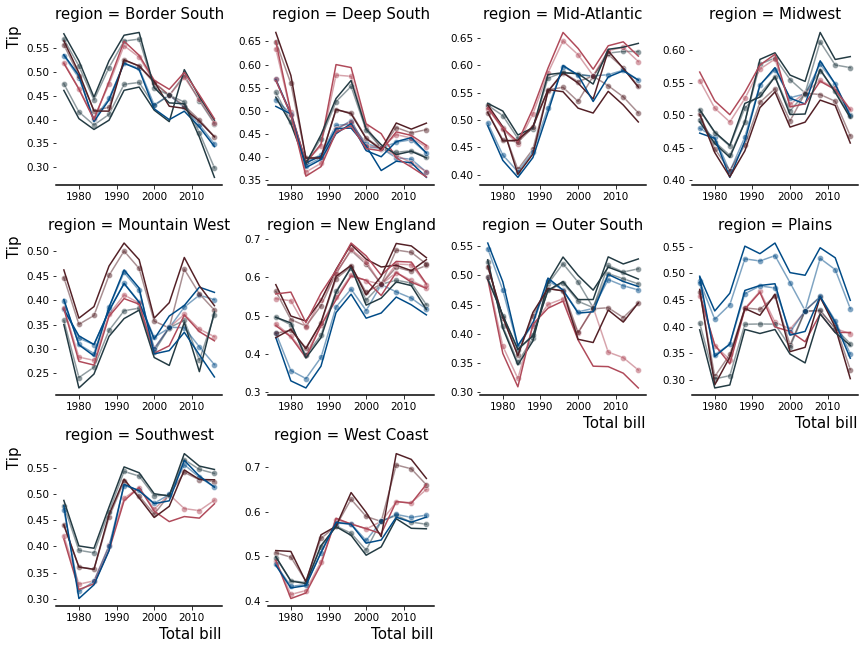

In [22]:
g = sns.FacetGrid(
    D, 
    col="region",
    hue="state",
    col_wrap=4,
    palette=palettes.discrete_diverging_colors(),
    sharex=False, 
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="year",
    y="y_hat", 
    style="state",
    marker="o",
    alpha=0.5
)
g.map_dataframe(
    sns.lineplot,
    x="year",
    y="proportion", 
    style="state",
)
g.set_axis_labels("Total bill", "Tip")
sns.despine(left=True)
plt.show()

In [23]:
D[D.state=="WA"]

,year,dem,rep,region,state,proportion,year_numerical,region_idxs,state_idxs,time_idxs,y_hat,y_hat_lower,y_hat_upper
506,1976,717323,777732,West Coast,WA,0.479797,0.0,9,49,0,0.481697,0.445388,0.517743
507,1980,650193,865244,West Coast,WA,0.429047,4.0,9,49,1,0.432726,0.395993,0.470219
508,1984,807352,1051670,West Coast,WA,0.434289,8.0,9,49,2,0.436577,0.400092,0.474341
509,1988,933516,903835,West Coast,WA,0.508077,12.0,9,49,3,0.508204,0.471174,0.544950
510,1992,993037,731234,West Coast,WA,0.575917,16.0,9,49,4,0.574254,0.537993,0.610243
511,1996,1123323,840712,West Coast,WA,0.571947,20.0,9,49,5,0.572591,0.536037,0.610309
512,2000,1247652,1108864,West Coast,WA,0.529448,24.0,9,49,6,0.535446,0.498269,0.574766
513,2004,1510201,1304894,West Coast,WA,0.536465,28.0,9,49,7,0.578102,0.490657,0.660380
514,2008,1750848,1229216,West Coast,WA,0.587520,32.0,9,49,8,0.593843,0.558210,0.629983
515,2012,1755396,1290670,West Coast,WA,0.576283,36.0,9,49,9,0.587097,0.552381,0.623681


In [24]:
np.mean(np.abs(D.proportion[~train_idxs].values - D.y_hat[~train_idxs].values))

DeviceArray(0.03667566, dtype=float32)

## A hierarchical GP model with coregionalisation

In [25]:
def coregional_model(y, Xu, n_times, time_idxs, n_states, 
          state_idxs, n_regions, region_idxs, train_idxs, n_states_per_region): 
    rho_region_gp = numpyro.sample("rho_region_gp", nd.LogNormal(0.0, 1.0))
    sigma_region_gp = numpyro.sample("sigma_region_gp", nd.LogNormal(0.0, 1.0))
    K_region_gp = rbf(Xu, Xu, sigma_region_gp, rho_region_gp)
    L_region_gp = np.linalg.cholesky(K_region_gp)
    with numpyro.plate("regions", size=n_regions):
        f_reg_tilde = numpyro.sample("f_reg_tilde", nd.Normal(loc=np.zeros((Xu.shape[0], 1))))
        f_reg = numpyro.deterministic("f_reg", L_region_gp @ f_reg_tilde)
    f_reg = np.repeat(f_reg, n_states_per_region, axis=1)
    f_reg = f_reg.T.reshape(-1)

    fs = []
    for i, q in enumerate(n_states_per_region):
        rho = numpyro.sample(f"rho_{i}", nd.LogNormal(0.0, 1.0))        
        K = rbf(Xu, Xu, 1.0, rho)
        L = np.linalg.cholesky(K + np.eye(K.shape[0]) * delta)
        sigma = numpyro.sample(f"sigma_{i}", nd.LogNormal(np.zeros(q), 1.0))
        omega = numpyro.sample(f"omega_{str(i)}", nd.LKJCholesky(q, 2.0))
        f_tilde = numpyro.sample(
            f"f_tilde_{i}", nd.Normal(loc=np.zeros((Xu.shape[0], q)))
        )
        f = numpyro.deterministic(
            f"f_{i}", L @ f_tilde @ (np.diag(np.sqrt(sigma)) @ omega).T            
        )
        fs.append(f.reshape(-1))
    f = np.concatenate(fs)
    
    nu = numpyro.sample("nu", nd.Gamma(5.0, 0.01))    
    mu = numpyro.sample("mu", nd.Normal(0.0, 0.5))
    eta = numpyro.deterministic("eta", nu * jax.scipy.special.expit(        
        mu + 
        f_reg +
        f
    ))
    numpyro.sample("y", nd.Beta(eta[train_idxs], nu - eta[train_idxs]), obs=y[train_idxs])

In [ ]:
mcmc_coregional = sample(coregional_model)

In [29]:
means, quantiles = predict(mcmc_coregional)

In [30]:
D = D.copy()
D.loc[:, "y_hat"] = onp.array(means)
D.loc[:, "y_hat_lower"] = onp.array(quantiles[0])
D.loc[:, "y_hat_upper"] = onp.array(quantiles[1])

DeviceArray(0.03009492, dtype=float32)

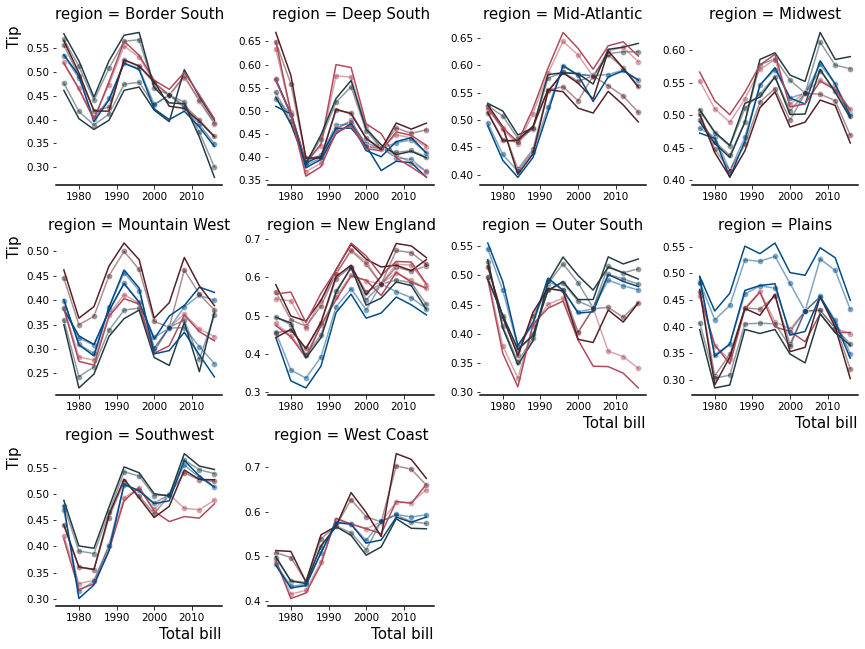

In [308]:
g = sns.FacetGrid(
    D, 
    col="region",
    hue="state",
    col_wrap=4,
    palette=palettes.discrete_diverging_colors(),
    sharex=False, 
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="year",
    y="y_hat", 
    style="state",
    marker="o",
    alpha=0.5
)
g.map_dataframe(
    sns.lineplot,
    x="year",
    y="proportion", 
    style="state",
)
g.set_axis_labels("Total bill", "Tip")
sns.despine(left=True)
plt.show()

In [33]:
Dc[Dc.state=="WA"]

,year,dem,rep,region,state,proportion,year_numerical,region_idxs,state_idxs,time_idxs,y_hat,y_hat_lower,y_hat_upper
506,1976,717323,777732,West Coast,WA,0.479797,0.0,9,49,0,0.486479,0.436968,0.536434
507,1980,650193,865244,West Coast,WA,0.429047,4.0,9,49,1,0.424153,0.380304,0.468383
508,1984,807352,1051670,West Coast,WA,0.434289,8.0,9,49,2,0.412470,0.367125,0.458743
509,1988,933516,903835,West Coast,WA,0.508077,12.0,9,49,3,0.479155,0.421927,0.534710
510,1992,993037,731234,West Coast,WA,0.575917,16.0,9,49,4,0.559791,0.515342,0.604755
511,1996,1123323,840712,West Coast,WA,0.571947,20.0,9,49,5,0.549649,0.502350,0.594983
512,2000,1247652,1108864,West Coast,WA,0.529448,24.0,9,49,6,0.527429,0.480143,0.575516
513,2004,1510201,1304894,West Coast,WA,0.536465,28.0,9,49,7,0.565549,0.465713,0.682544
514,2008,1750848,1229216,West Coast,WA,0.587520,32.0,9,49,8,0.597635,0.546027,0.649252
515,2012,1755396,1290670,West Coast,WA,0.576283,36.0,9,49,9,0.592753,0.541722,0.644195


In [32]:
np.mean(np.abs(Dc.proportion[~train_idxs].values - Dc.y_hat[~train_idxs].values))

DeviceArray(0.03009492, dtype=float32)